# The Geometric (Analytical) Approach for Inverse Kinematics
The geometric approach for inverse kinematics only offers solutions based on a certain conditions.

- Condition 1: the number of degrees of freedom (DOF) should be equal to the dimensions of the task space. For instance, if we move in 2D, our robotic arm must have 2 DOF. This means that our robot will have a finite number of solutions; otherwise, it will have no solution of an infinite number. 


In [45]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random


In [46]:
class Link:
    def __init__(self, length, theta_deg, parent=None):
        """
        Constructor:
        - theta_deg: angle in degrees (relative to x axis or to parent link)
        - length   : link length
        - parent   : other link object (optional)
        """
        self.theta = math.radians(theta_deg)
        self.length = float(length)
        self.parent = parent
        
        # The link is defined by its its reference transform (related to its parent), 
        # its rotation matrix, and its coordinates
        
        
        if parent is None: # This link has no parent → its base is at the origin
            
            # Reference transform
            self.refTransform = np.array([
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]
            ])
            self.x0, self.y0 = 0.0, 0.0
            self.theta_base = 0
        else:
            # its base is in the end point of its parent link
            # Reference transform
            self.refTransform = np.array([
                [1,         0, self.parent.length],
                [0,         1,                  0],
                [0,         0,                  1]
            ])
            
        # Rotation Matrix
        self.rotationMatrix = matriz = np.array([
            [np.cos(self.theta), -np.sin(self.theta),   0],
            [np.sin(self.theta),  np.cos(self.theta),   0],
            [0                 ,                   0,   1]
        ])
        
        # link coordinate about x axis
        self.coordinates = matriz = np.array([
            [self.length],
            [0],
            [1]
        ])
    
    def update(self):
        # Rotation Matrix
        self.rotationMatrix = matriz = np.array([
            [np.cos(self.theta), -np.sin(self.theta),   0],
            [np.sin(self.theta),  np.cos(self.theta),   0],
            [0                 ,                   0,   1]
        ])
        
        
    def calculateLinkTransform(self):
        
        if self.parent is None:
            return np.dot(self.refTransform,self.rotationMatrix)
        else:
            return np.dot(self.parent.calculateLinkTransform(),np.dot(self.refTransform,self.rotationMatrix))
        
    
    def calculateWorldCoordinates(self):
            return np.dot(self.calculateLinkTransform(),self.coordinates)

In [47]:
# ==============================================================
# Create a set of links using the parent link
# ==============================================================
link1 = Link(3, 0)              # first link
link2 = Link(3, 45, link1)      # second link

links = [link1, link2]

In [48]:
print(f'Reference transform: \n{links[-1].refTransform}')
print(f'Rotation matrix: \n{links[-1].rotationMatrix}')
print(f'Link transform: \n{links[-1].calculateLinkTransform()}')
print(f'World coordinates: \n{links[-1].calculateWorldCoordinates()}')


Reference transform: 
[[1. 0. 3.]
 [0. 1. 0.]
 [0. 0. 1.]]
Rotation matrix: 
[[ 0.70710678 -0.70710678  0.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]
Link transform: 
[[ 0.70710678 -0.70710678  3.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.          0.          1.        ]]
World coordinates: 
[[5.12132034]
 [2.12132034]
 [1.        ]]


In [49]:
print(f'reference transform: \n{links[0].refTransform}')
print(f'Rotation matrix: \n{links[0].rotationMatrix}')
print(f'World coordinates: \n{links[0].calculateWorldCoordinates()}')


reference transform: 
[[1 0 0]
 [0 1 0]
 [0 0 1]]
Rotation matrix: 
[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
World coordinates: 
[[3.]
 [0.]
 [1.]]


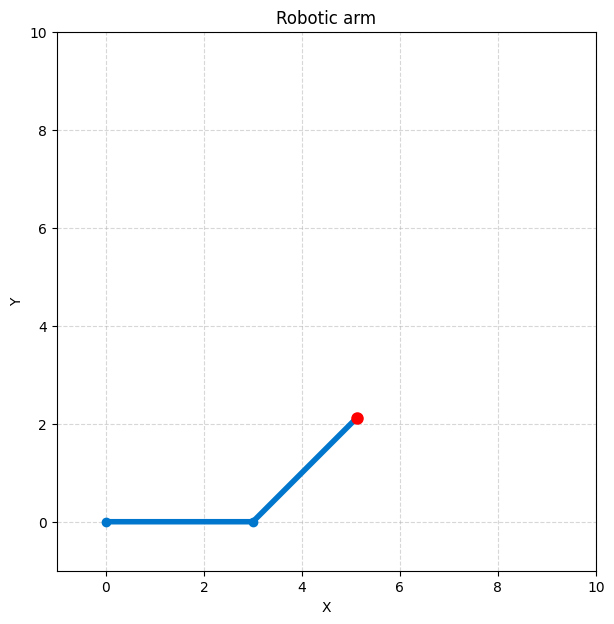

In [50]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_aspect('equal', 'box')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Robotic arm")

ax.set_xlim(-1, 10)
ax.set_ylim(-1, 10)

(lineas,) = ax.plot([], [], lw=4, marker='o', color="#0077cc", markersize=6)
(end_dot,) = ax.plot([], [], 'o', color='red', markersize=8)

# Calculate chained positions
x_points = [0.0]
y_points = [0.0]

length_links = 0
for link in links:
    coordinates = link.calculateWorldCoordinates()
    x_points.append(coordinates[0,0])
    y_points.append(coordinates[1,0])
    length_links += link.length
    
# print arm
lineas.set_data(x_points, y_points)
end_dot.set_data([x_points[-1]], [y_points[-1]])
plt.show()


## 2R Robotic Arm
The 2R Robotic Arm consist in a 2 DOF Robot with revolution (or rotary joints). So, if we want to solve its inverse kinematics analytically, we must fixed our task space to be 2D. 

In [51]:
# ==============================================================
# Initial set condition of the robot
# ==============================================================
L1= 3
L2 = 2
q1 = 0
q2 = 0

# Create the links of the robot
link1 = Link(L1, q1)              # first link
link2 = Link(L2, q2, link1)      # second link
links = [link1, link2]

# Maximum and minimum squared norm of the robot
max_norm2 = (L1 + L2)**2
min_norm2 = (L1 - L2)**2

In [52]:
def calculateQ(point):
    # Squared norm of the point
    norm_point2 = point[0]**2 + point[1]**2 # x² + y²
    theta = math.atan2(point[1],point[0])
    
    # q2 cosine
    c2 = (norm_point2 - L1**2 - L2**2)/(2*L1*L2)
    
    if c2 > 1:
        print("The point is out of reach (above its maximum norm)")
        return None
    
    elif c2 < -1:
        print("The point is out of reach (below its minimum norm)")
        return None
        
    elif c2 == 1: # maximum reach
        q2 = 0 #
        q1 = theta
    
    elif c2 ==-1 and math.sqrt(norm_point2)!=0 :
        q2 = np.pi
        q1 = theta
        
    elif c2 ==-1 and math.sqrt(norm_point2)==0 :
        q2 = np.pi
        q1 = random.uniform(0, 2*math.pi)
        
    else:
        q2 = [math.acos(c2),-math.acos(c2)]
        q1 = []
        for item in q2:
            q1.append(theta - math.atan2(L2*math.sin(item),L1+L2*math.cos(item)))
            
    return q1,q2
        


In [53]:
def showArm(point):
    fig, ax = plt.subplots(figsize=(7, 7))

    ax.set_aspect('equal', 'box')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Robotic arm")

    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

    (lineas,) = ax.plot([], [], lw=4, marker='o', color="#0077cc", markersize=6)
    (end_dot,) = ax.plot([], [], 'o', color='red', markersize=8)
    point_p, = ax.plot([], [], 'o', color="green", markersize=8)


    # Calculate chained positions
    x_points = [0.0]
    y_points = [0.0]

    length_links = 0
    for link in links:
        coordinates = link.calculateWorldCoordinates()
        x_points.append(coordinates[0,0])
        y_points.append(coordinates[1,0])
        length_links += link.length
        
    # print arm
    lineas.set_data(x_points, y_points)
    end_dot.set_data([x_points[-1]], [y_points[-1]])
    
    point_p.set_data([point[0]], [point[1]])

    plt.show()


Desired position (x,y): 8, 8
Current end effector position (x,y): [5.], [0.]
The point is out of reach (above its maximum norm)
angle 1: 0 and angle 2: 0
Final end effector position (x,y): [5.], [0.]


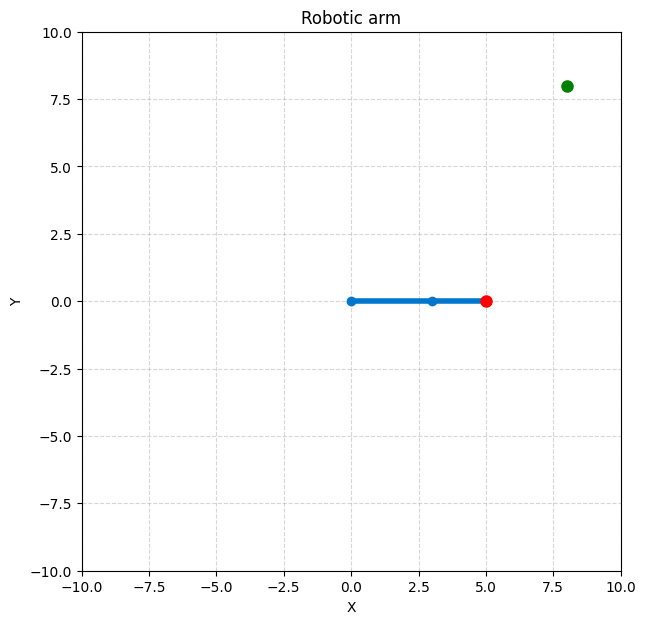

In [54]:
point = (8,8)

q1,q2 =0,0
coordinates =links[-1].calculateWorldCoordinates()
print(f'Desired position (x,y): {point[0]}, {point[1]}')
print(f'Current end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

result = calculateQ(point)
if result is not None:
    q1,q2 = result
    if type(q1) == float:
        links[0].theta = q1
        links[1].theta = q2
    else:
        links[0].theta = q1[0]
        links[1].theta = q2[0]
        
for link in links:
    link.update()
print(f'angle 1: {q1} and angle 2: {q2}')
coordinates =links[-1].calculateWorldCoordinates()
print(f'Final end effector position (x,y): {coordinates[0]}, {coordinates[1]}')
showArm(point)
        

Desired position (x,y): 4.330127018922194, 2.4999999999999996
Current end effector position (x,y): [5.], [0.]
angle 1: 0.5235987755982987 and angle 2: 0
Final end effector position (x,y): [4.33012702], [2.5]


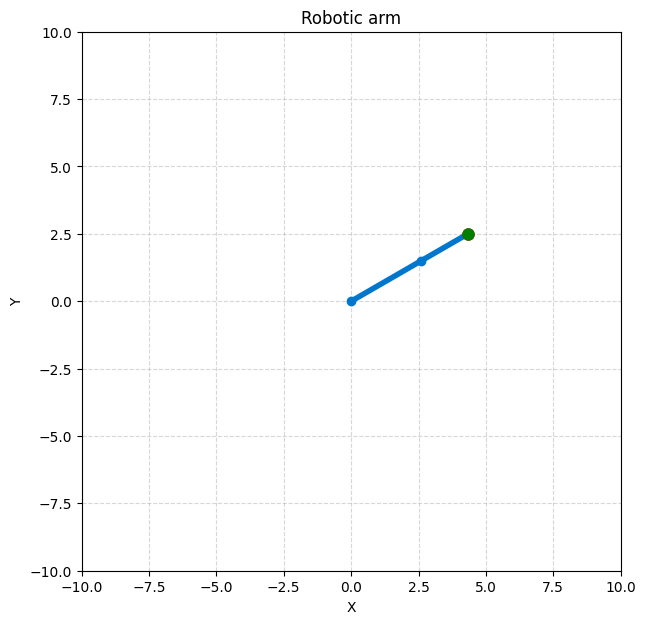

In [55]:
point = ((L1+L2)*math.cos(math.radians(30)),(L1+L2)*math.sin(math.radians(30)))

coordinates =links[-1].calculateWorldCoordinates()
print(f'Desired position (x,y): {point[0]}, {point[1]}')
print(f'Current end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

result = calculateQ(point)
if result is not None:
    q1,q2 = result
    if type(q1) == float:
        links[0].theta = q1
        links[1].theta = q2
    else:
        links[0].theta = q1[0]
        links[1].theta = q2[0]
        
for link in links:
    link.update()
print(f'angle 1: {q1} and angle 2: {q2}')
coordinates =links[-1].calculateWorldCoordinates()
print(f'Final end effector position (x,y): {coordinates[0]}, {coordinates[1]}')
showArm(point)
        

Desired position (x,y): 3, 3
Current end effector position (x,y): [4.33012702], [2.5]
angle 1: [0.3425277878259627, 1.2282685389689338] and angle 2: [1.141020895490369, -1.141020895490369]
Final end effector position (x,y): [3.], [3.]


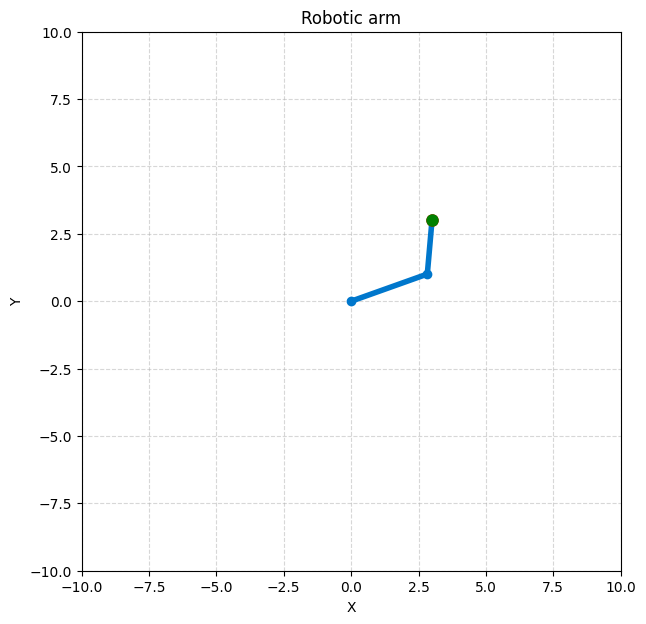

In [56]:
point = (3,3)

coordinates =links[-1].calculateWorldCoordinates()
print(f'Desired position (x,y): {point[0]}, {point[1]}')
print(f'Current end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

result = calculateQ(point)
if result is not None:
    q1,q2 = result
    if type(q1) == float:
        links[0].theta = q1
        links[1].theta = q2
    else:
        links[0].theta = q1[0]
        links[1].theta = q2[0]
        
for link in links:
    link.update()
print(f'angle 1: {q1} and angle 2: {q2}')
coordinates =links[-1].calculateWorldCoordinates()
print(f'Final end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

showArm(point)

        

Desired position (x,y): 0.8660254037844387, 0.49999999999999994
Current end effector position (x,y): [3.], [3.]
angle 1: 0.5235987755982988 and angle 2: 3.141592653589793
Final end effector position (x,y): [0.8660254], [0.5]


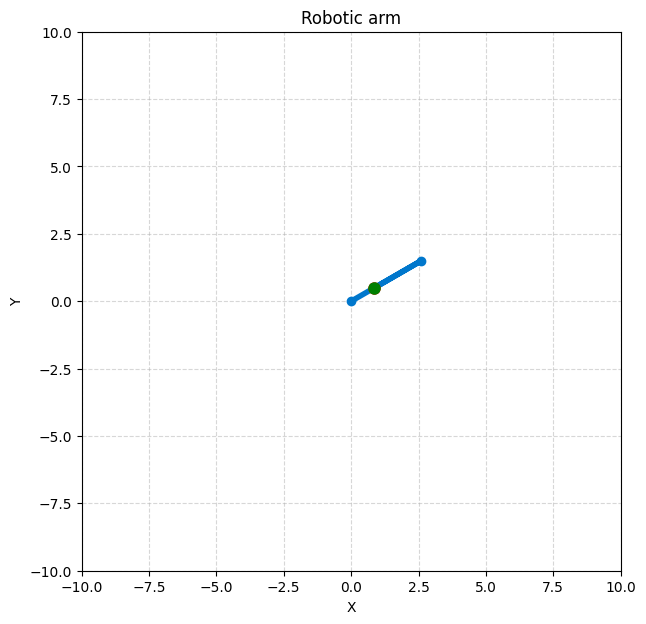

In [57]:
point = ((L1-L2)*math.cos(math.radians(30)),(L1-L2)*math.sin(math.radians(30)))

coordinates =links[-1].calculateWorldCoordinates()
print(f'Desired position (x,y): {point[0]}, {point[1]}')
print(f'Current end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

result = calculateQ(point)
if result is not None:
    q1,q2 = result
    if type(q1) == float:
        links[0].theta = q1
        links[1].theta = q2
    else:
        links[0].theta = q1[0]
        links[1].theta = q2[0]
        
for link in links:
    link.update()
print(f'angle 1: {q1} and angle 2: {q2}')
coordinates =links[-1].calculateWorldCoordinates()
print(f'Final end effector position (x,y): {coordinates[0]}, {coordinates[1]}')
showArm(point)
        

Desired position (x,y): 0, 0
Current end effector position (x,y): [0.8660254], [0.5]
The point is out of reach (below its minimum norm)
angle 1: 0.5235987755982988 and angle 2: 3.141592653589793
Final end effector position (x,y): [0.8660254], [0.5]


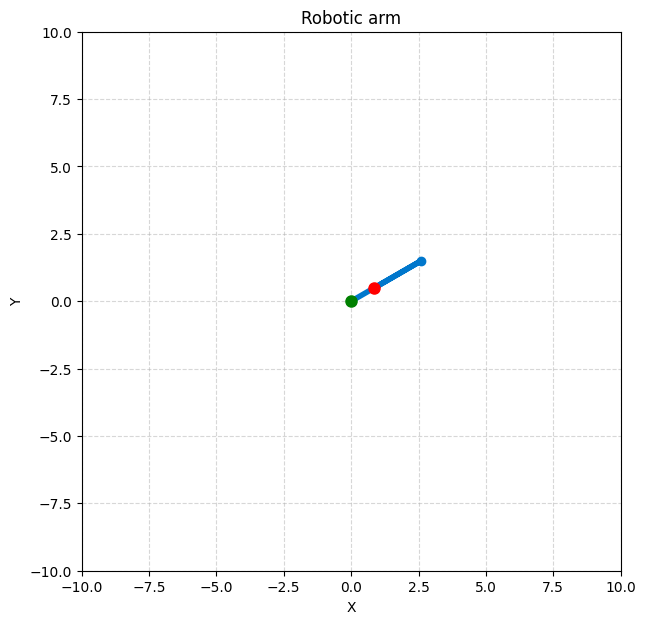

In [58]:
point = (0,0)

coordinates =links[-1].calculateWorldCoordinates()
print(f'Desired position (x,y): {point[0]}, {point[1]}')
print(f'Current end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

result = calculateQ(point)
if result is not None:
    q1,q2 = result
    if type(q1) == float:
        links[0].theta = q1
        links[1].theta = q2
    else:
        links[0].theta = q1[0]
        links[1].theta = q2[0]
        
for link in links:
    link.update()
print(f'angle 1: {q1} and angle 2: {q2}')
coordinates =links[-1].calculateWorldCoordinates()
print(f'Final end effector position (x,y): {coordinates[0]}, {coordinates[1]}')
showArm(point)

        

# Robot using the library

In [59]:
from robot2r import Robot2r

robot = Robot2r(3,2,0,0)

In [60]:
def showRobotpos(robot,point):
    fig, ax = plt.subplots(figsize=(7, 7))

    ax.set_aspect('equal', 'box')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title("Robotic arm")

    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

    (lineas,) = ax.plot([], [], lw=4, marker='o', color="#0077cc", markersize=6)
    (end_dot,) = ax.plot([], [], 'o', color='red', markersize=8)
    point_p, = ax.plot([], [], 'o', color="green", markersize=8)

    # Calculates the coordinates of robot's joints
    x_points,y_points = robot.robotCoordinates()
        
    # print arm
    lineas.set_data(x_points, y_points)
    end_dot.set_data([x_points[-1]], [y_points[-1]])
    
    point_p.set_data([point[0]], [point[1]])

    plt.show()

Desired position (x,y): 8, 8
Current end effector position (x,y): [5.], [0.]
The point is out of reach (above its maximum norm)
Robot angle 1: 0 and angle 2: 0
Final end effector position (x,y): [5.], [0.]


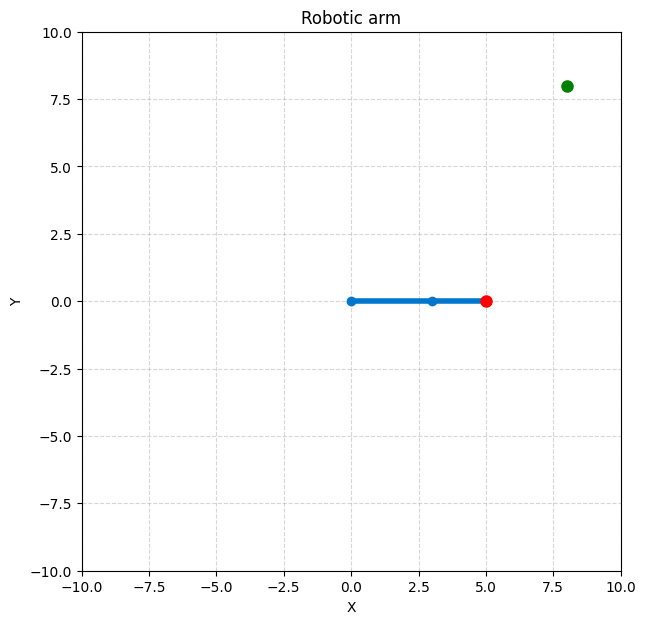

In [61]:
point = (8,8)

coordinates = robot.endeffectorPos()
print(f'Desired position (x,y): {point[0]}, {point[1]}')
print(f'Current end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

robot.move2point(point)
print(f'Robot angle 1: {robot.q1} and angle 2: {robot.q2}')
coordinates = robot.endeffectorPos()
print(f'Final end effector position (x,y): {coordinates[0]}, {coordinates[1]}')
showRobotpos(robot,point)
        

Desired position (x,y): 4.330127018922194, 2.4999999999999996
Current end effector position (x,y): [5.], [0.]
Robot angle 1: 0.5235987755982987 and angle 2: 0
Final end effector position (x,y): [4.33012702], [2.5]


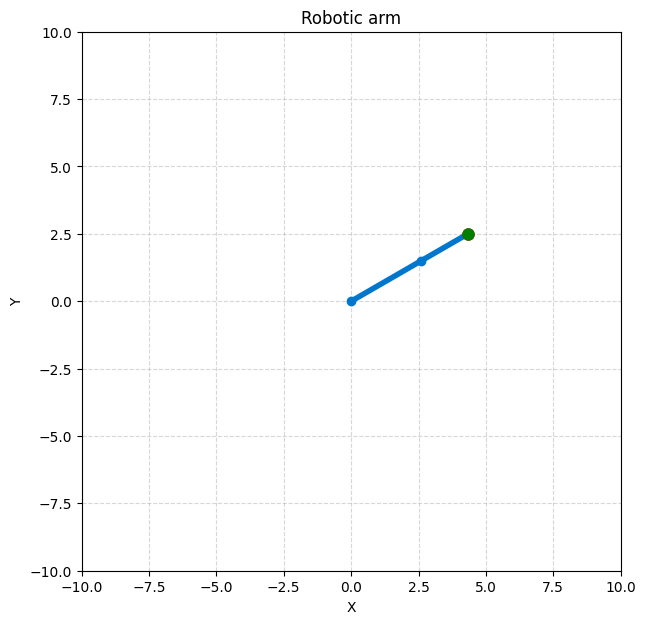

In [62]:
point = ((robot.L1+robot.L2)*math.cos(math.radians(30)),(robot.L1+robot.L2)*math.sin(math.radians(30)))

coordinates = robot.endeffectorPos()
print(f'Desired position (x,y): {point[0]}, {point[1]}')
print(f'Current end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

robot.move2point(point)

print(f'Robot angle 1: {robot.q1} and angle 2: {robot.q2}')
coordinates = coordinates = robot.endeffectorPos()
print(f'Final end effector position (x,y): {coordinates[0]}, {coordinates[1]}')
showRobotpos(robot,point)
        

Desired position (x,y): 3, 3
Current end effector position (x,y): [4.33012702], [2.5]
Robot angle 1: 0.3425277878259627 and angle 2: 1.141020895490369
Final end effector position (x,y): [3.], [3.]


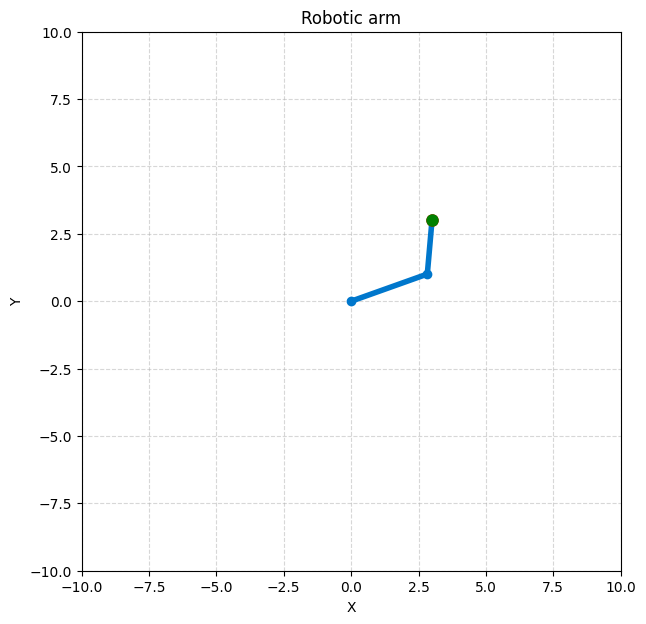

In [63]:
point = (3,3)

coordinates = robot.endeffectorPos()
print(f'Desired position (x,y): {point[0]}, {point[1]}')
print(f'Current end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

robot.move2point(point)
print(f'Robot angle 1: {robot.q1} and angle 2: {robot.q2}')
coordinates = coordinates = robot.endeffectorPos()
print(f'Final end effector position (x,y): {coordinates[0]}, {coordinates[1]}')
showRobotpos(robot,point)
        

Desired position (x,y): 0.8660254037844387, 0.49999999999999994
Current end effector position (x,y): [3.], [3.]
Robot angle 1: 0.5235987755982988 and angle 2: 3.141592653589793
Final end effector position (x,y): [0.8660254], [0.5]


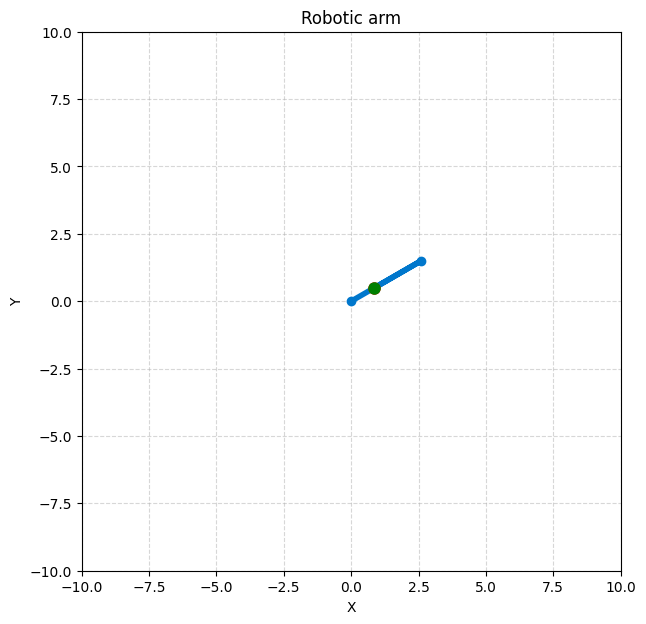

In [64]:
point = ((L1-L2)*math.cos(math.radians(30)),(L1-L2)*math.sin(math.radians(30)))

coordinates = robot.endeffectorPos()
print(f'Desired position (x,y): {point[0]}, {point[1]}')
print(f'Current end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

robot.move2point(point)
print(f'Robot angle 1: {robot.q1} and angle 2: {robot.q2}')
coordinates = coordinates = robot.endeffectorPos()
print(f'Final end effector position (x,y): {coordinates[0]}, {coordinates[1]}')
showRobotpos(robot,point)
        

Desired position (x,y): 0, 0
Current end effector position (x,y): [0.8660254], [0.5]
The point is out of reach (below its minimum norm)
Robot angle 1: 0.5235987755982988 and angle 2: 3.141592653589793
Final end effector position (x,y): [0.8660254], [0.5]


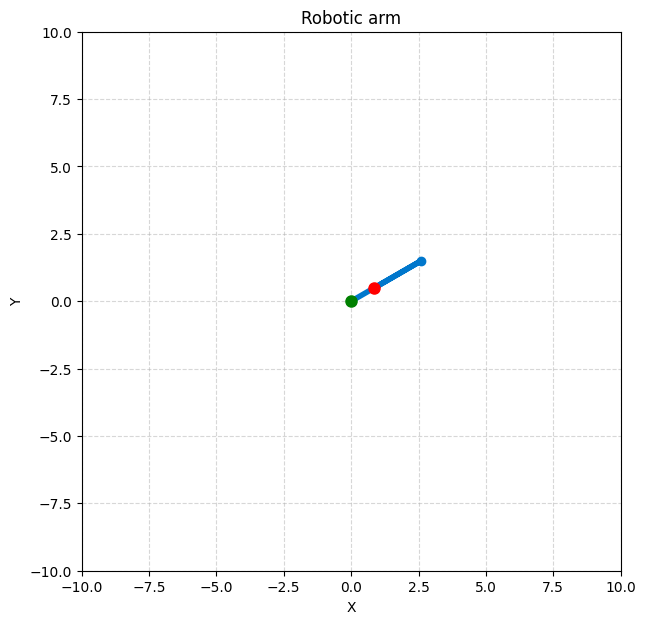

In [65]:
point = (0,0)

coordinates = robot.endeffectorPos()
print(f'Desired position (x,y): {point[0]}, {point[1]}')
print(f'Current end effector position (x,y): {coordinates[0]}, {coordinates[1]}')

robot.move2point(point)
print(f'Robot angle 1: {robot.q1} and angle 2: {robot.q2}')
coordinates = coordinates = robot.endeffectorPos()
print(f'Final end effector position (x,y): {coordinates[0]}, {coordinates[1]}')
showRobotpos(robot,point)
        